<a href="https://colab.research.google.com/github/jtracos/DNN_Models/blob/main/GAN_SatImg_Seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocesamiento

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, utils, models, initializers
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
### preprocessing
### Data is satellite imagery from ASTER
### Targets are the vegetation and water


In [4]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive

Mounted at /gdrive
/gdrive


In [5]:
PATH = "MyDrive/data/SatelliteImagery/"
files = [file for file in os.listdir(PATH) if "valor" in file]
print(files)

['NVDI-1-valor.tiff', 'NDWIXU-1-valor.tiff', 'NBR-1-valor.tiff']


In [9]:
def plot_img_from_dir(dir, file):
  """Plotting from tiff images"""
  img_file = plt.imread(dir+file)
  img_file = img_file[:,:,0:-1]
  img_file.shape
  _ = plt.figure(figsize=(10,10))
  plt.title(file)
  _ = plt.imshow(np.where(img_file==0, 255, 0), cmap= plt.cm.binary_r)
## patching images
def patching_img(dir, file):
  """Patching image"""
  img = plt.imread(dir+ file)[:,:,:-1]
  patches = tf.image.extract_patches(tf.expand_dims(img, 0), sizes=[1,100,100,1], strides=[1,100,100,1], rates=[1,1,1,1], padding="VALID")
  print(f"img shape: {img.shape}")
  print(f"patches shape: {patches.shape}")
  return patches

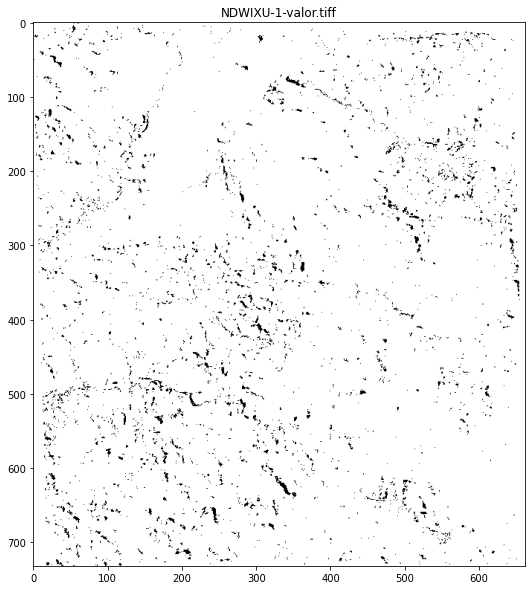

In [14]:
## agua
plot_img_from_dir(PATH,files[1])

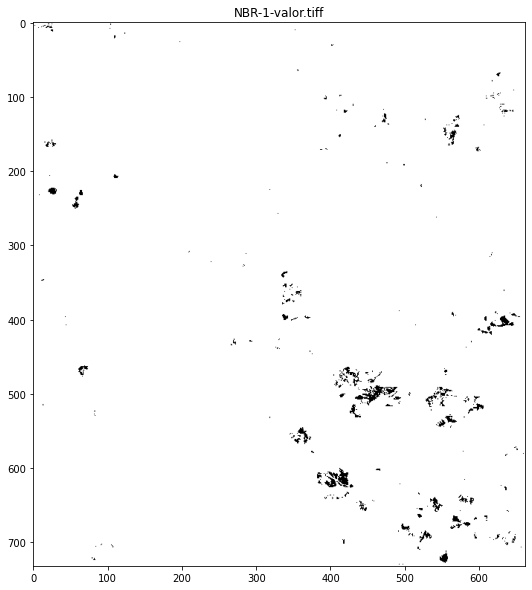

In [15]:
## quemadura
plot_img_from_dir(PATH,files[2])

## Ejemplo

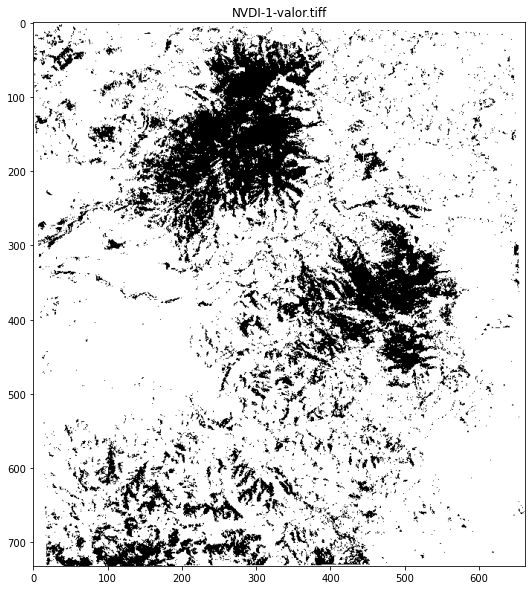

In [5]:
## vegetacion
## Imagen original
plot_img_from_dir(PATH,files[0])

In [11]:
## Genera 42 imagenes de 100,100,3 a partir de 
## una imagen de 700+,600+,3 en listas de
## 3*100*100 elementos(pixeles)
patches = patching_img(PATH,files[0])
dim_1 = patches.shape[1]
dim_2 = patches.shape[2]

img shape: (732, 663, 3)
patches shape: (1, 7, 6, 30000)


In [12]:
dataset = patches.numpy().reshape(dim_1,dim_2, 100,100,-1)
#dataset = tf.data.Dataset.from_tensor_slices(dataset)
dataset.shape

(7, 6, 100, 100, 3)

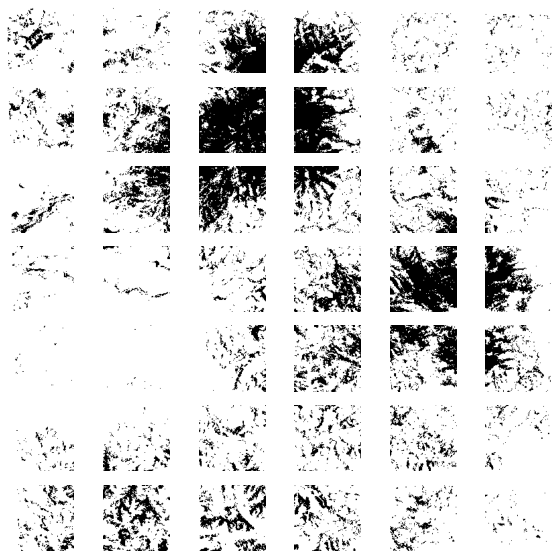

In [13]:
## imagen original recortada a  imagenes de 100x100x3
fig, axes = plt.subplots(dim_1, dim_2, figsize =(10,10))
for row in range(dim_1):
  for col in range(dim_2):
    axes[row,col].imshow(np.where(dataset[row,col,:,:,:]==0, 255, 0), cmap= plt.cm.binary_r)
    axes[row,col].axis("off")

El conjunto de datos a procesar se conforma de recortes de las imagenes originales.
Se clasifica como positivo a cada subimagen con una cobertura de vegetacion/agua superior al 80%
El modelo debe predecir si es agua o vegetacion(como valores de probabilidad) y generar una distribucion espacial estimada de la cobertura.

In [ ]:
##Random data for testing porpuse
img_data = tf.random.uniform([size]+img_shape[:2]+[1],minval=0, maxval=255, dtype=tf.int32)
img_data = tf.where(img_data<100, 0,255)
img_targets = tf.random.uniform([size]+ img_shape,minval=0, maxval=255, dtype= tf.int32)
img_data[0].get_shape()

TensorShape([1024, 1024, 1])

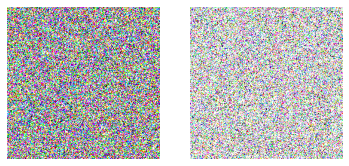

In [ ]:
img = tf.image.extract_patches(tf.expand_dims(img_data[0,:,:,:],0), sizes=[1,4,4,1], strides=[1,4,4,1], rates=[1,1,1,1], padding="VALID")
fig, axes = plt.subplots(1,2)
for ax in axes:
  ax.axis("off")
axes[0].imshow(img[0,:,:,:3])
axes[1].imshow(img[0,:,:,3:7])

In [ ]:
ax.gr
f, ax = plt.subplots(1,2, figsize = (16,16))
#create a generator
dataset = tf.data.Dataset.from_tensor_slices(img_data)
img =dataset.take(1)
_ = ax[0].imshow(tf.cast(next(iter(img)), tf.int32))
ax[0].set_title("X")
_ = ax[1].imshow(tf.cast(next(iter(img)), tf.int32))
ax[1].set_title("Target")

## GAN Pix2Pix for image segmentation

In [ ]:
#Developing the GAN
def define_discriminator(image_shape=(256,256,3)):
  # weight initialization
  init = initializers.RandomNormal(stddev=0.02)
  # source image input
  in_src_image = layers.Input(shape=image_shape)
  # target image input
  in_target_image = layers.Input(shape=image_shape)
  # concatenate images channel-wise
  merged = layers.Concatenate()([in_src_image, in_target_image])
  # C64
  d = layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = layers.LeakyReLU(alpha=0.2)(d)
  # C128
  d = layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = layers.BatchNormalization()(d)
  d = layers.LeakyReLU(alpha=0.2)(d)
  # C256
  d = layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = layers.BatchNormalization()(d)
  d = layers.LeakyReLU(alpha=0.2)(d)
  # C512
  d = layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = layers.BatchNormalization()(d)
  d = layers.LeakyReLU(alpha=0.2)(d)
  # second last output layer
  d = layers.Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
  d = layers.BatchNormalization()(d)
  d = layers.LeakyReLU(alpha=0.2)(d)
  # patch output
  d = layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init )(d)
  patch_out = layers.Activation('sigmoid', name = "Predictor")(d)
  # define model
  model = models.Model([in_src_image, in_target_image], patch_out, name = "Discriminative_Model" )
  # compile model
  opt = optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model


In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
  """ layer_in: capa de sobre la que se acopla el boque codificador
  n_filters: numero de filtros(nodos) para la capa convolucional
  """
	# weight initialization
  init = initializers.RandomNormal(stddev=0.02)
  # add downsampling layer
  g = layers.Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  # conditionally add batch normalization
  if batchnorm:
    g = layers.BatchNormalization()(g, training=True)
  # leaky relu activation
  g = layers.LeakyReLU(alpha=0.2)(g)
  return g

  ###########################
 ## define a decoder block ##
###########################
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  """inputs:
  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    layer_in: capa subsecuente al bloque decodificador
    skip_in: capa a enlazar al bloque decodificador
    n_filters: numero de nodos en la capa de deconvolucion

  return:
  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  g: capa con el bloque codificador agregado al grafo
  """
	# weight initialization
  init = initializers.RandomNormal(stddev=0.02)
	# add upsampling layer
  g = layers.Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  # add batch normalization
  g = layers.BatchNormalization()(g, training=True)
  # conditionally add dropout
  if dropout:
    g = layers.Dropout(0.5)(g, training=True)
	# merge with skip connection
  g = layers.Concatenate()([g, skip_in])
	# relu activation
  g = layers.Activation('relu')(g)
  return g

###########################################
## define the standalone generator model ##
###########################################

def define_generator(image_shape=(256,256,3)):
  """Crea el generador Pix2Pix
  Retorna la parte generativa del modelo"""
  # weight initialization
  init = initializers.RandomNormal(stddev=0.02)
  # image input
  in_image = layers.Input(shape=image_shape)
  # encoder model
  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)
  # bottleneck, no batch norm and relu
  b = layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = layers.Activation('relu')(b)
  # decoder model
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  # output
  g = layers.Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_image = layers.Activation('tanh', name= "Generator_output")(g)
  # define model
  model = models.Model(in_image, out_image, name = "Conv_Generative_Model" )
  return model

In [ ]:

def inv_jaccard_similarity_loss(alpha=1, beta=1):
  def jaccard_similarity_loss(y_true, y_pred):
    
    epsilon = 2e-3
    tf.multiply(K.flatten(y_true), K.flatten(y_pred)
    prod = tf.matmul(y_true, y_pred)
    a = tf.constant(1.)
    dif_y_true = tf.math.subtract(a, y_true)
    dif_y_pred = tf.math.subtract(a, y_pred)
    den = alpha*dif_y_true + beta*dif_y_pred + prod
    loss = (prod + epsilon )/(den+epsilon)
    return 1 - loss
    return jaccard_similarity_loss
def define_gan(g_model, d_model, image_shape):
  """
            DCGAN
  """
  # make weights in the discriminator not trainable
  for layer in d_model.layers:
    if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = False
  # define the source image
  in_src = layers.Input(shape=image_shape, name = "img_source")
  # connect the source image to the generator input
  gen_out = g_model(in_src)
  # connect the source input and generator output to the discriminator input
  dis_out = d_model([in_src, gen_out])
  # src image as input, generated image and classification output
  model = models.Model(in_src, [dis_out, gen_out],name = "DCGAN")
  # compile model
  opt = optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=[inv_jaccard_similarity_loss(), 'mae'], optimizer=opt, loss_weights=[1,100])#'binary_crossentropy', 'mae'
  return model

In [ ]:
## Modelo final
## genera dos salidas:
## 1.- Imagen con los rasgos de interes
## 2._ clase a la que pertenece
K.clear_session()
g_model = define_generator()
d_model = define_discriminator(image_shape=img_shape)
gan_model = define_gan(g_model, d_model, img_shape)

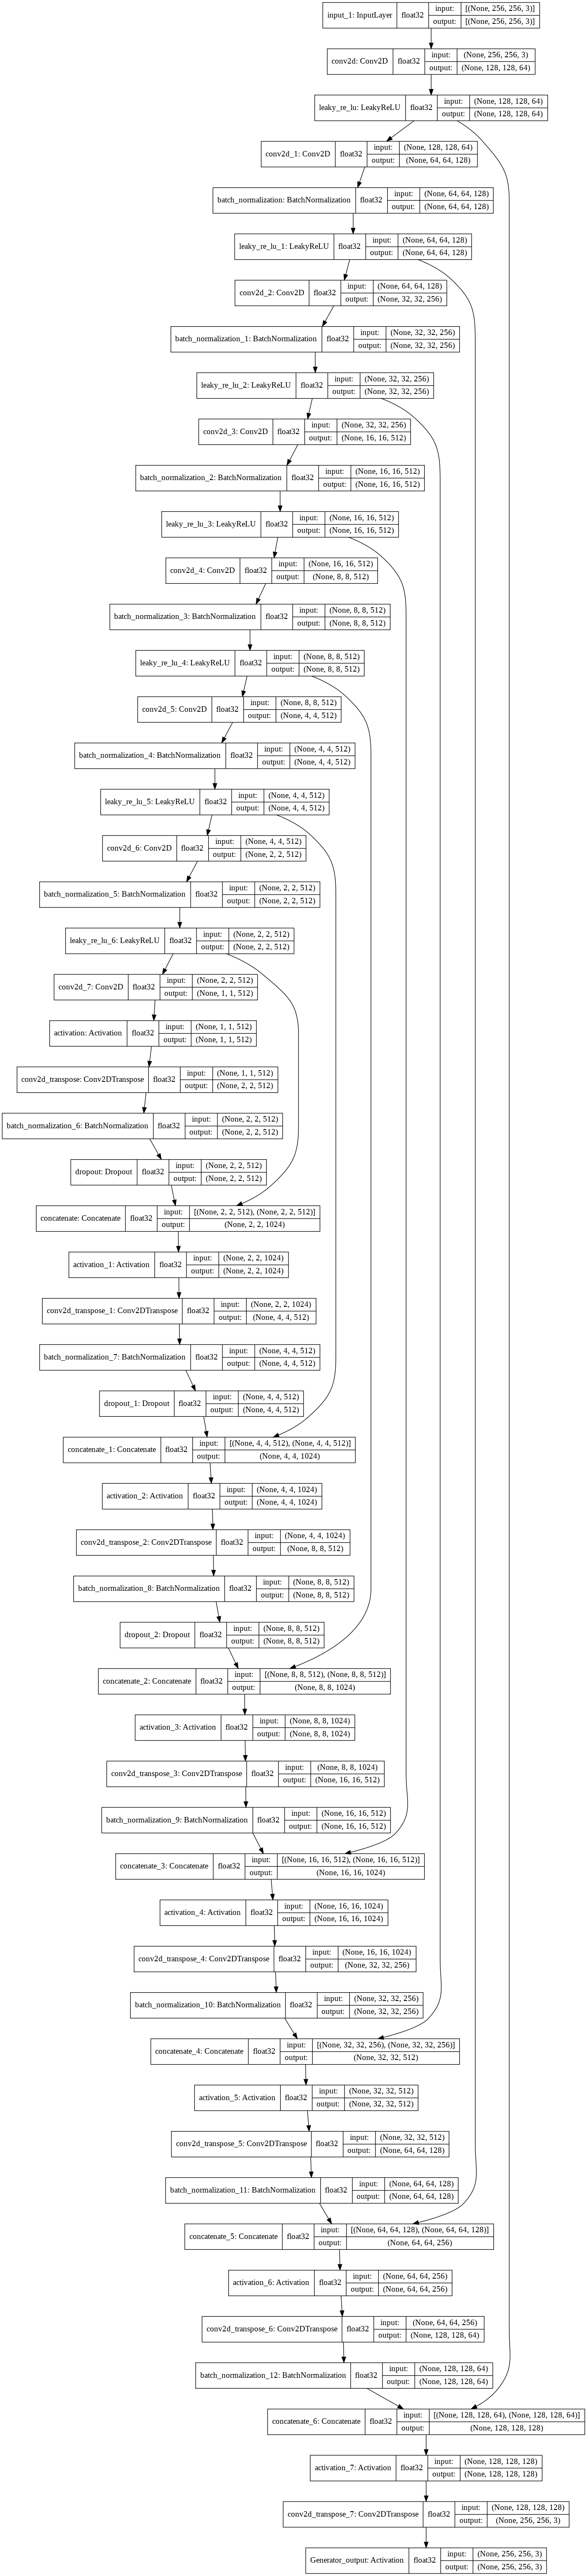

In [ ]:
utils.plot_model(g_model, show_dtype = True, show_shapes = True)

In [ ]:
utils.plot_model(d_model, show_dtype = True, show_shapes = True)

In [ ]:
## Las siguientes funciones se escriben como ejemplo
## Es más conveniente generar los datos y preprocesarlos con tf.keras y tf.data
def generate_real_samples(dataset, n_samples, patch_shape):
  """Crea muestras del conjunto de datos para clasificarlos como correctas
  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  dataset: Conjunto de datos"""
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

def generate_fake_samples(g_model, samples, patch_shape):
  """Genera datos falsos a partir del generador no entrenado"""
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [ ]:
utils.plot_model(g_model,show_shapes=True,show_layer_names=True)

In [ ]:
utils.plot_model(d_model,show_shapes=True,show_layer_names=True)

In [ ]:
utils.plot_model(gan_model,show_shapes=True,show_layer_names=True)

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	
  # manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)